# NLP 6iCa -  Assignment 3
## Author: Benjamin Brodwolf
### Date: 11.05.2020

__________________________________________________________________________________________________________________________

## HINWEIS: Word2Vec-File wird benötigt
Benutze das vortraintierten Embedding von Glove: [Glove-6B-300D](https://nlp.stanford.edu/projects/glove/) 

Kann hier herundergeladen werden: [KLICKE HIER](http://nlp.stanford.edu/data/glove.6B.zip)

In [1]:
# Übergebe hier den Pfad zur "glove.6B.300d.txt"-Datei

path_to_word2vec = "glove.6B.300d.txt"

In [4]:
import pandas as pd
import numpy as np
from numpy import array

import gensim
from nltk import word_tokenize

import re 
from nltk.corpus import stopwords

from spellchecker import SpellChecker

from gensim.models.word2vec import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

from keras import backend as K
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils import resample, class_weight

import matplotlib.pyplot as plt

AttributeError: module 'brotli' has no attribute 'error'

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [4]:
def prepareData():
    print("Laden der Reviews: Amazon_Baby_train.txt ")
    df = pd.read_csv("./Amazon_Baby_train.txt", sep=";", names=["Rate", "Product", "Review"])
    df.drop("Product", axis=1, inplace=True)

    print("\nEntfernen von Leeren Reviews...")
    # entfernen Reviews mit NaN und empty strings
    df.dropna(inplace=True)
    empty_review = [] 
    for i, rate, rev in df.itertuples():  
        if type(rev)==str:           
            if rev.isspace():         
                empty_review.append(i)    
    df.drop(empty_review, inplace=True)
    return df
    
def reviewSizes(colum):
    print("Beschreibung der Review-Grössen\n")
    df[colum + "_len"] = df[colum].str.len()
    all_len = df[colum + "_len"].tolist() #[l for l in df["len"]]
    plt.figure()
    plt.title( colum + "_len Text-Grössen Plot")  
    plt.xlabel(colum)
    plt.ylabel(colum + "_len")
    plt.plot(all_len)
    plt.show()
    print(pd.Series(all_len).describe())    
    
    
def cleaining(rev, stopwords):
    
    # smileys chatcher AWESOME oder TERRIBLE
    happy_smile = '(:\)|:\-\)|:\)\)|:\-\)\)|:D|:\-\D|;\-\)|:\-D)+'
    rev = re.sub(happy_smile, ' awesome ', rev)    
    
    terrible_smile = '(:\(|:\-\(|:\/|:\-/)+'
    rev = re.sub(terrible_smile, ' terrible ', rev)   
    
    # alles klein
    rev = rev.lower()
    
    # entferne Zahlen
    rev = re.sub(r'\d+', '', rev)

    # Apostrophs fixes
    rev = re.sub(r" im ", " i am ", rev)
    rev = re.sub(r" isnt ", " is not ", rev)
    rev = re.sub(r" dont ", " do not ", rev)
    rev = re.sub(r" didnt ", " did not ", rev)
    rev = re.sub(r" alot ", " a lot ", rev)
    rev = re.sub(r" won\'t ", " will not ", rev)
    rev = re.sub(r" can\'t ", " can not ", rev)
    rev = re.sub(r"n\'t", " not ", rev)
    rev = re.sub(r"\'t", " not ", rev)
    rev = re.sub(r" wouldnt ", " would not ", rev)
    rev = re.sub(r" doesnt ", " does not ", rev)
    rev = re.sub(r"\'ve ", " have ", rev)
    rev = re.sub(r"\'m ", " am ", rev)
    rev = re.sub(r"\'re ", " are ", rev)
    rev = re.sub(r"\'s ", " is ", rev)
    rev = re.sub(r"\'d ", " would ", rev)
    rev = re.sub(r"\'ll ", " will ", rev)
    
    # Misspelling correction
    rev = re.sub(r"extrememly", "extremely", rev)
    rev = re.sub(r"recomend|reccomend|reccommend", "recommend", rev)
    rev = re.sub(r"terrifing", "terrifying", rev)
    rev = re.sub(r"instad", "instead", rev)
    rev = re.sub(r"recieved", "received", rev)
    rev = re.sub(r"favorites", "favorit", rev)
    rev = re.sub(r"dissapointed", "disappointed", rev)
    rev = re.sub(r"bummed", "cheap", rev)
    rev = re.sub(r"alot", "many", rev)
    rev = re.sub(r"excelente|excelent", "excellent", rev)    

    rev = re.compile(r"(.)\1{2,}").sub(r"\1\1", rev) # entfernt zu extra lange Buchtstaben-Folgen zB. finallllly => finally
    rev = re.sub(r"\b[e|d|m|n|t|s|b|o]\b", "", rev) # entferne alleine stehende Buchstaben
    #rev = re.sub(r"and", "", rev) # kein and und the
    #rev = re.sub(r'([||"|»|«|~|#|\§$/%"\=+→.,/\{\|}\|(|\|)|\|[\];*!?\':\-])+', " ", rev) # entferne unbrauchbare Zeichen
    
    rev = re.sub('[^a-z0-9]+', " ", rev)
    rev = re.sub("\s+", " ", rev)

    rev_token = word_tokenize(rev)

    if stopwords:
        rev_token = [w for w in rev_token if  w.isalpha() and (w not in stopwords_E or w in whitelist) and len(w) > 1] 

    return rev_token

def show_rating_values(data, labels):
    data = sorted(data.value_counts().items())
    data = [x[1] for x in data] 
    for i in range(len(data)):
        print(f"{labels[i]}: {data[i]}")
    plt.figure(figsize=(5, 5))
    plt.pie(data, labels=labels, autopct='%1.1f%%');
    plt.show()

def create_sequence(data):
    encoded_set = tokenizer.texts_to_sequences(data["clean"])
    encoded_set_padded = pad_sequences(
        encoded_set, 
        maxlen=MAX_REV_LENGTH, 
        padding="pre",
        truncating="pre") 
    
    data["Seq"] = [list(var) for var in encoded_set_padded]
    return np.array([np.array(token) for token in data["Seq"]])


def create_embedding_matrix(vocab_size, word2vec_path, token_word_index):

    glove_input = word2vec_path #"./glove.6B.300d.txt"
    word2vec_output = "./glove.6B.300d.txt.word2vec" 
    glove2word2vec(glove_input, word2vec_output)
    
    try:
        embeddings_index = gensim.models.KeyedVectors.load_word2vec_format( word2vec_output, binary=False)
    except:
        print("Error! 'glove.6B.300d.txt' konnte nicht geladen/gefunden werden!")
    
    embedding_matrix = np.zeros((vocab_size, 300))
    missed = []
    for word, i in token_word_index.items():
        try:
            embedding_vector = embeddings_index[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            missed.append(word)
            
    return [embedding_matrix, missed, embeddings_index]

def y_test_predict(model, x_test, y_test, classes = ["1","2","3","4","5"]):
    evalus = model.evaluate(x_test, y_test, verbose = 1)
    print(evalus)
    
    y_test_predict = model.predict(x_test, verbose=1)
    metric = metrics.classification_report(y_test.argmax(axis=1), y_test_predict.argmax(axis=1), target_names=classes)
    print(metric)
    return y_test_predict, evalus, metric
  
    
def plot_graphs(model):
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1) 
    plt.title("model loss")
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.legend(["loss", "val_loss"])
    
    plt.subplot(1,3,2)
    plt.title("model accuracy")
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.legend(["accuracy", "val_accuracy"])

    
    plt.subplot(1,3,3)
    plt.title("F1 value")
    plt.plot(model.history.history["F1"])
    plt.plot(model.history.history["val_F1"])
    plt.xlabel("Epochs")
    plt.ylabel("F1")
    plt.legend(["F1", "val_F1"])
    plt.show()
    
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    print('Confusion matrix')
    
    print(cm)
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def print_metrics(evalus):
    print(f"Loss:     {evalus[0]:.4f} \nAccuracy: {evalus[1]:.4f} \nF1:       {evalus[2]:.4f} \n")

## Preprocessing

Laden der Reviews: Amazon_Baby_train.txt 

Entfernen von Leeren Reviews...
Beschreibung der Review-Grössen



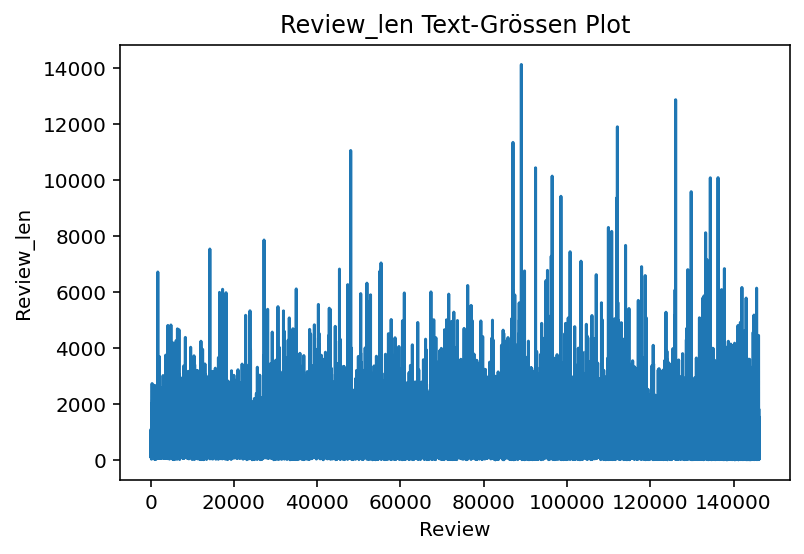

count    146195.000000
mean        431.117822
std         461.622200
min           3.000000
25%         163.000000
50%         290.000000
75%         525.000000
max       14130.000000
dtype: float64


In [5]:
df = prepareData() # Laden und bereitstellen der DataFrame

reviewSizes("Review")

In [6]:
stopwords_E = set(stopwords.words('english'))
whitelist = ["not", "no", "very", "more", "most", "nor"]


_____________________________________________
Säubern der Reviews (lower, remove digits)
_____________________________________________
Cleaned token Reviews:
Beschreibung der Review-Grössen



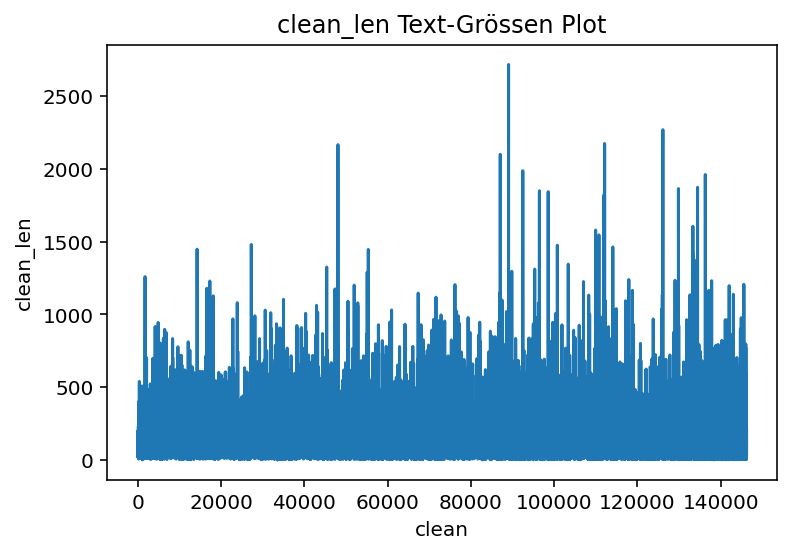

count    146195.000000
mean         83.350758
std          88.587477
min           0.000000
25%          31.000000
50%          56.000000
75%         102.000000
max        2717.000000
dtype: float64


In [7]:
print("_____________________________________________\nSäubern der Reviews (lower, remove digits)")
df["clean"] = df["Review"].apply(lambda row : cleaining(row, False)) # True = entferne Englisch Stopwords

print("_____________________________________________\nCleaned token Reviews:")
reviewSizes("clean")

df[df["clean_len"] <= 1][:15] 

for token in df["clean"]:
    for w in token:
        if(w == "awesome"):
            print(token)

Beschreibung der Review-Grössen



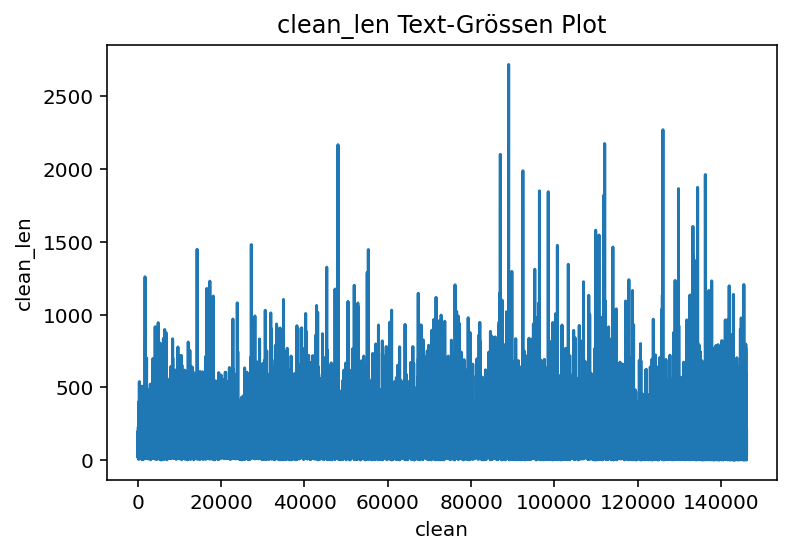

count    146117.000000
mean         83.394766
std          88.590633
min           2.000000
25%          31.000000
50%          56.000000
75%         102.000000
max        2717.000000
dtype: float64


In [8]:
# entferne die zu kurzen und leeren Reviews
df.drop(df[df["clean_len"] <= 1 ].index, inplace=True )
reviewSizes("clean")

_____________________________________________
Unkown words:
Beschreibung der Review-Grössen



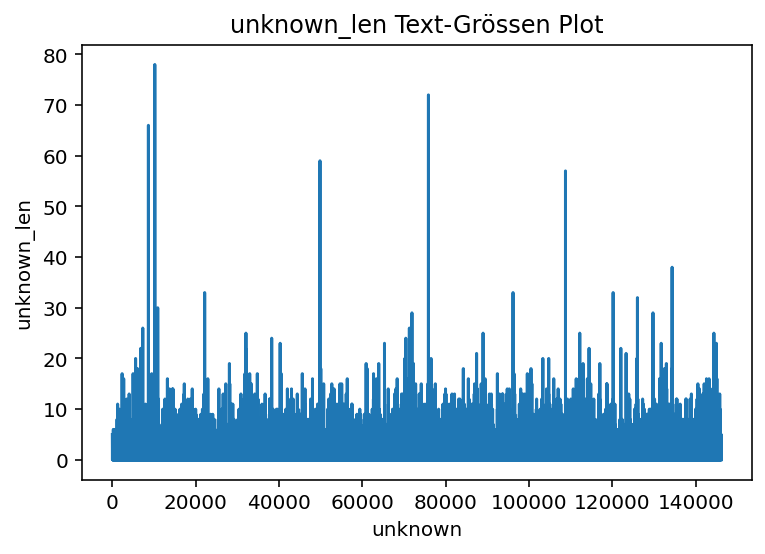

count    146117.000000
mean          0.851858
std           1.488905
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          78.000000
dtype: float64


In [9]:
spell = SpellChecker()
df["unknown"] = df["clean"].apply(lambda row: spell.unknown(row))

print("_____________________________________________\nUnkown words:")
reviewSizes("unknown")        

In [10]:
df[df["unknown_len"] >= 7 ]

,Rate,Review,Review_len,clean,clean_len,unknown,unknown_len
1138,5.0,My three year old son started training a yea...,1851,"[my, three, year, old, son, started, training,...",360,"{alones, ellapsed, spongebob, disstraction, ga...",8
1277,4.0,I have a six month old son (Patrick) and he ...,1569,"[i, have, a, six, month, old, son, patrick, an...",297,"{quottots, chicco, quot, quotluv, althoug, exe...",11
1414,3.0,I bought this pump after reading all the rav...,2084,"[i, bought, this, pump, after, reading, all, t...",377,"{medela, engorgement, medella, momsmaternity, ...",7
1428,5.0,This is the best breast pump I have tried. ...,1696,"[this, is, the, best, breast, pump, i, have, t...",329,"{sanitize, medela, restroom, disassembles, int...",7
1540,5.0,"I have gotten breast pumps in the past, and ...",495,"[i, have, gotten, breast, pumps, in, the, past...",98,"{playtex, goddes, puchashing, becasue, untill,...",7
...,...,...,...,...,...,...,...
146529,5.0,After finding out that I was expecting baby ...,2505,"[after, finding, out, that, i, was, expecting,...",472,"{baggie, cupholder, kolcraft, carseat, strolle...",7
146531,4.0,This is a very well designed organizer bag f...,2466,"[this, is, a, very, well, designed, organizer,...",423,"{zippered, ttachment, http, graco, modeled, st...",13
146640,3.0,I am not going to preach to you all about ho...,3936,"[i, am, not, going, to, preach, to, you, all, ...",773,"{sanitize, clunks, ipod, donno, ebay, craigsli...",10
146642,2.0,"A friend told us to get this, said it was a ...",1309,"[a, friend, told, us, to, get, this, said, it,...",246,"{programsmusic, speakersyour, neitherthe, blin...",9


Beschreibung der Review-Grössen



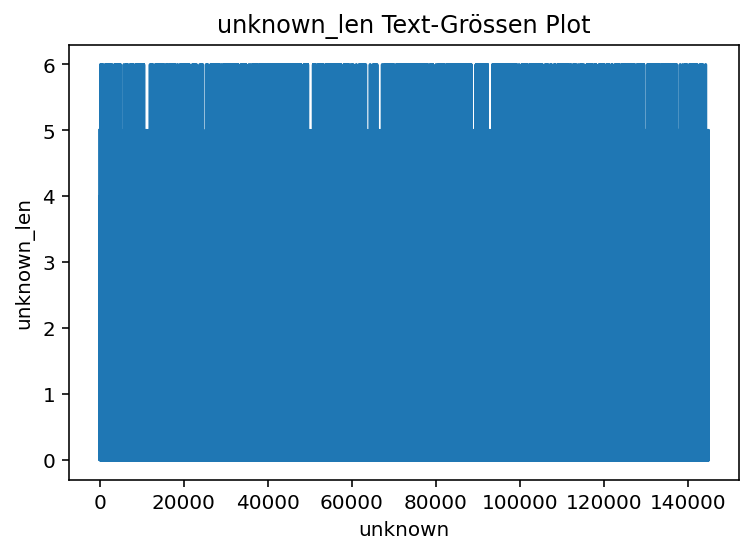

count    144778.000000
mean          0.769164
std           1.122197
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           6.000000
dtype: float64


In [11]:
# entferne die texte mit zu vielen fehler - sind auch Reviews mit anderen Sprache zB. Spanisch
df.drop(df[df["unknown_len"] >= 7 ].index, inplace=True )
reviewSizes("unknown")    

In [12]:
df[df["unknown_len"] >= 4][:10]

,Rate,Review,Review_len,clean,clean_len,unknown,unknown_len
0,3.0,"These flannel wipes are OK, but in my opinio...",454,"[these, flannel, wipes, are, ok, but, in, my, ...",78,"{vimse, usingthirsties, boyfor, countwhich, so...",5
112,4.0,Our whole family loved the Mozart music bloc...,516,"[our, whole, family, loved, the, mozart, music...",95,"{quotchip, quotplug, quot, quotdisk}",4
125,4.0,We received this as a present for our 6 mont...,330,"[we, received, this, as, a, present, for, our,...",63,"{quot, lamaze, quotcrinkly, fishbowl}",4
193,5.0,"Not that==> I &lt==would -- ever -- do it, o...",647,"[not, that, i, lt, would, ever, do, it, or, re...",112,"{eggsprank, therattlesnake, noticethe, upwhen}",4
225,5.0,We have another vibrating teether that is ve...,660,"[we, have, another, vibrating, teether, that, ...",131,"{activatei, teether, variancethis, favors}",4
228,2.0,I had this very teether for my twin boys 8 y...,1422,"[i, had, this, very, teether, for, my, twin, b...",261,"{teether, phthalates, labeling, bpa, phthalate}",5
239,5.0,We purchased the Babysling when our daughter...,1588,"[we, purchased, the, babysling, when, our, dau...",297,"{quot, babysling, quotinvolved, colicy, quotto...",6
304,5.0,My biggest concern was would this truly cont...,454,"[my, biggest, concern, was, would, this, truly...",93,"{diapes, deodorizers, thelid, odor}",4
370,3.0,We received the Diaper Champ as a shower gif...,381,"[we, received, the, diaper, champ, as, a, show...",66,"{odors, eminate, odor, smellier}",4
384,5.0,My sister had a Diaper Genie and it always s...,707,"[my, sister, had, a, diaper, genie, and, it, a...",138,"{trashbag, trashbags, odor, odors}",4


In [13]:
def word_frequence(data):
    wordfreq = {}
    for dic in data:
        for word in dic:
            if word not in wordfreq:
                wordfreq[word] = 0 
            wordfreq[word] += 1
    return wordfreq
            
unkown_dic = word_frequence(df["unknown"])

for key, value in sorted(unkown_dic.items(), key=lambda kv: kv[1], reverse=True):
    print("%s: %s" % (key, value))


stroller: 7665
sippy: 2049
carseat: 1788
graco: 1775
britax: 1587
medela: 1440
bassinet: 1217
avent: 1196
colorful: 1024
moms: 1010
pacifiers: 1005
swaddle: 911
teether: 896
website: 724
bpa: 632
chicco: 617
playtex: 597
odor: 584
maneuver: 541
boppy: 532
diapering: 493
munchkin: 477
evenflo: 453
nuk: 404
cribs: 401
walmart: 394
suv: 368
reclines: 351
prefolds: 348
paci: 327
teethers: 322
jumperoo: 299
carseats: 283
thirsties: 264
cuter: 242
anais: 240
zippered: 236
odors: 234
snuggly: 232
decals: 229
sterilize: 229
playard: 223
perego: 222
emailed: 219
exersaucer: 218
snugride: 216
ameda: 215
lansinoh: 214
favorit: 204
traveled: 196
sleepsack: 196
keyfit: 195
babys: 193
fyi: 192
recaro: 191
washcloths: 190
grandbaby: 190
joovy: 189
squirmy: 187
transitioning: 187
pediatrician: 186
iphone: 185
grandaughter: 180
kiddos: 177
tommee: 177
bugaboo: 177
grandkids: 175
lamaze: 172
swaddles: 171
nuby: 170
soothie: 169
wifi: 169
bumbo: 165
uppababy: 165
youtube: 163
disassemble: 161
blankie: 15

buttom: 4
repost: 4
hv: 4
carle: 4
ultrasounds: 4
crinkley: 4
freetimes: 4
peva: 4
shorties: 4
zinnia: 4
contigo: 4
silikids: 4
microterry: 4
geat: 4
basix: 4
acurate: 4
robeez: 4
unrolls: 4
pacimal: 4
muno: 4
gogurt: 4
thebritax: 4
superlatch: 4
producti: 4
roomiest: 4
absorbtion: 4
babywear: 4
issies: 4
tieing: 4
pacigrips: 4
qty: 4
dishware: 4
suri: 4
becaus: 4
canapy: 4
organickidz: 4
jk: 4
hade: 4
juust: 4
orbelle: 4
updatei: 4
fanciest: 4
starsi: 4
expencive: 4
durably: 4
counterclockwise: 4
flexibath: 4
bebek: 4
comfty: 4
pavillion: 4
karmel: 4
cush: 4
plusses: 4
broked: 4
motorolla: 4
amperage: 4
namebrand: 4
ceva: 4
wonderbug: 4
groupon: 4
bsafe: 4
alvababy: 4
sunblocks: 4
couldn: 4
backflow: 4
trimness: 4
dlink: 4
grovias: 4
rumina: 4
snuggie: 4
babyz: 4
tomee: 4
cami: 4
prezi: 4
mixie: 4
kidzikoo: 4
pouchpop: 4
ipotty: 4
woolzies: 4
choomee: 4
thery: 3
appts: 3
haning: 3
espicially: 3
ordor: 3
poopies: 3
bjs: 3
dissapear: 3
refils: 3
eminating: 3
espeically: 3
durabilty: 3
p

childen: 2
lanisol: 2
sideway: 2
glueing: 2
diaappointed: 2
easilyoverall: 2
paniers: 2
fuzzybunz: 2
chincy: 2
rfing: 2
mema: 2
handmedown: 2
heafty: 2
tldr: 2
milimeters: 2
excersize: 2
securecons: 2
grippiness: 2
veru: 2
chicagoland: 2
unsewed: 2
horizonal: 2
klick: 2
socked: 2
proudct: 2
itelf: 2
pinzon: 2
dappis: 2
biweekly: 2
cames: 2
polysorbate: 2
bottlesi: 2
hoppop: 2
wovens: 2
flexiable: 2
happyit: 2
puls: 2
cuteybaby: 2
mudpie: 2
cribe: 2
waching: 2
boosa: 2
jipped: 2
stongly: 2
sanbox: 2
braclet: 2
avacado: 2
babyboy: 2
acosco: 2
cushystraps: 2
konks: 2
slicers: 2
constructioncons: 2
trivet: 2
yuckiness: 2
unbuckles: 2
sytle: 2
uselss: 2
utencils: 2
nasakleen: 2
scarry: 2
iwth: 2
konw: 2
scratchier: 2
wellmade: 2
fantasticly: 2
funkoos: 2
plent: 2
alpix: 2
crunchier: 2
boder: 2
convienience: 2
lovesit: 2
personlized: 2
downi: 2
isoflex: 2
standup: 2
storch: 2
storchenwiege: 2
wms: 2
stayes: 2
colorings: 2
divisol: 2
dropperful: 2
ddrops: 2
absoultly: 2
umph: 2
tooks: 2
laker

drainable: 1
toileteries: 1
epmty: 1
alcoholed: 1
perfusely: 1
dauthger: 1
duoi: 1
originanlly: 1
grammee: 1
increedibly: 1
uninterupted: 1
oversixed: 1
possing: 1
sdisconnected: 1
conswe: 1
secureand: 1
recommendationdefinitely: 1
themwished: 1
fedexed: 1
decatholon: 1
presess: 1
stylewise: 1
funner: 1
noisemakes: 1
cinemate: 1
otheres: 1
wirless: 1
restupright: 1
inisde: 1
colores: 1
boworred: 1
featuresso: 1
falvybabyswede: 1
babyswede: 1
minumum: 1
simpli: 1
olderyes: 1
bedwhile: 1
incledible: 1
floorpad: 1
stading: 1
sometines: 1
windproofing: 1
onhowever: 1
bermanauthor: 1
unavailible: 1
chnaged: 1
resoved: 1
gunny: 1
hyp: 1
hunnypie: 1
tize: 1
omd: 1
actived: 1
steping: 1
daughterand: 1
recommendedin: 1
twicthed: 1
extendablecons: 1
nosesit: 1
adjustablesince: 1
househould: 1
aloha: 1
swiper: 1
buisiness: 1
christmnas: 1
manuvarability: 1
unaccessable: 1
swollowed: 1
graphitewhich: 1
firstwheels: 1
bottel: 1
procare: 1
emroidery: 1
hydrates: 1
favoritism: 1
unfortuanately: 1
him

reaslised: 1
techo: 1
signficant: 1
laundrymat: 1
presprayed: 1
inforce: 1
bussines: 1
molteni: 1
cassina: 1
icff: 1
minotti: 1
zebrawood: 1
medford: 1
anywayit: 1
gobios: 1
sealys: 1
mattressi: 1
walmrt: 1
urchase: 1
suppliment: 1
asleepcons: 1
pocketif: 1
utiltize: 1
specifcally: 1
ridiculus: 1
secerate: 1
mininit: 1
multiable: 1
rechargeing: 1
pullstring: 1
oohh: 1
strollar: 1
orbitbaby: 1
sysytem: 1
anywho: 1
rediculious: 1
wallhanging: 1
mesmorizes: 1
loottss: 1
bellideep: 1
arizonan: 1
allarming: 1
aroun: 1
rearlly: 1
whels: 1
otcmaster: 1
varymelted: 1
theseplaytex: 1
setdid: 1
fews: 1
nitwit: 1
filty: 1
prettying: 1
bball: 1
expectative: 1
boyit: 1
jettakid: 1
minoer: 1
pleae: 1
buylove: 1
exterra: 1
roomer: 1
texturing: 1
steeringcons: 1
spousal: 1
makig: 1
rebeca: 1
biteable: 1
heavyhandle: 1
ithard: 1
closenot: 1
usetod: 1
redused: 1
tthese: 1
prefilling: 1
brail: 1
bbuurrp: 1
firstyear: 1
browms: 1
nees: 1
constipate: 1
padfold: 1
flouring: 1
dring: 1
saltbut: 1
brokenpinat

eatchildren: 1
alongeasy: 1
fromeasy: 1
washandyou: 1
downa: 1
fountainer: 1
washi: 1
forky: 1
promptcons: 1
covercarters: 1
sageand: 1
lansolin: 1
maela: 1
honkeysuckle: 1
simplese: 1
defrozen: 1
receintly: 1
wonderul: 1
whenenver: 1
roughhouse: 1
supersaving: 1
compltetly: 1
cglist: 1
candal: 1
dishwashwer: 1
drinkcons: 1
thatoverall: 1
strawcups: 1
reopend: 1
varybut: 1
varysince: 1
wonks: 1
entired: 1
anndd: 1
depressurize: 1
dmage: 1
afriad: 1
skipits: 1
mll: 1
craftiness: 1
separtely: 1
aquality: 1
andshe: 1
usesless: 1
frustates: 1
frustation: 1
soundbox: 1
jjust: 1
losened: 1
pinkaholic: 1
tisues: 1
bloches: 1
comfortablest: 1
coushins: 1
doozie: 1
comphy: 1
armpads: 1
willast: 1
therockers: 1
assbled: 1
mybrother: 1
restained: 1
everytine: 1
misguiding: 1
clunker: 1
oncerned: 1
goig: 1
giraffeworks: 1
onewubbanub: 1
caterpillarcons: 1
headlock: 1
immediated: 1
floot: 1
handsone: 1
wubbies: 1
wubbabnub: 1
lolshe: 1
bulkyfits: 1
sectionthe: 1
diapersdisappointed: 1
hopeclosing: 

oromotor: 1
diepers: 1
ussualy: 1
retest: 1
boudreauxs: 1
lotrimin: 1
balmex: 1
triderma: 1
cointainer: 1
bresast: 1
alhtough: 1
frotier: 1
proctection: 1
utlize: 1
britix: 1
furstrating: 1
bulleted: 1
bowlsphilips: 1
monthsinstead: 1
hewanted: 1
bmilk: 1
sleve: 1
supereasy: 1
excellentcustomer: 1
wirelss: 1
ibused: 1
hoever: 1
enoughmajor: 1
weightsound: 1
andweather: 1
mantioned: 1
appletv: 1
onvideo: 1
amazonthe: 1
dxrs: 1
monitorsand: 1
sporatic: 1
throwning: 1
softoverall: 1
airportexpress: 1
timecapsule: 1
airportextreme: 1
aiportextreme: 1
ginuea: 1
satifisfied: 1
vidoe: 1
inactivitythings: 1
batteryi: 1
yourside: 1
internetwhen: 1
montitors: 1
degredation: 1
conservers: 1
neccessities: 1
perefectly: 1
tolder: 1
cylon: 1
lits: 1
automuting: 1
indiscernable: 1
wantthis: 1
vison: 1
twoway: 1
explaination: 1
highpitch: 1
blitzes: 1
objectshowever: 1
dealcheap: 1
beaps: 1
dissapopinted: 1
ehighest: 1
pulg: 1
camers: 1
hickups: 1
prorating: 1
godsent: 1
priviously: 1
lase: 1
uws: 1
s

devasting: 1
tetrised: 1
displayand: 1
strobing: 1
snazzier: 1
outie: 1
espa: 1
ntildeola: 1
mivabke: 1
storefuture: 1
greatgran: 1
dmdr: 1
ethelle: 1
albiet: 1
ineashed: 1
shimmie: 1
perfered: 1
kinley: 1
eary: 1
isnow: 1
wateri: 1
immediatelyi: 1
lolmaybe: 1
cleanwhat: 1
disform: 1
gadly: 1
miricle: 1
bddistributers: 1
luckbut: 1
cottonbut: 1
nookums: 1
thefgood: 1
catchings: 1
yoo: 1
landen: 1
tentwith: 1
oredered: 1
pluggy: 1
overi: 1
deatial: 1
nuktrendline: 1
snapsin: 1
aventis: 1
makesportions: 1
notsomething: 1
cankind: 1
workswell: 1
backwords: 1
unmerciful: 1
itstraps: 1
driffent: 1
handlea: 1
changr: 1
selant: 1
offten: 1
warmness: 1
fedious: 1
favouably: 1
screenprinting: 1
isfalling: 1
poco: 1
podido: 1
utilizarlo: 1
holdersthe: 1
dau: 1
zended: 1
normalizes: 1
childtells: 1
coldlove: 1
colormultiple: 1
pricedcons: 1
niceadditional: 1
udw: 1
unidens: 1
indicatoretcetcso: 1
diningyou: 1
lightbaby: 1
timenot: 1
satisfactoryoften: 1
giggledots: 1
orgnazed: 1
fgor: 1
hsnd: 1
b

In [14]:
known_dic = word_frequence(df["clean"])

for key, value in sorted(unkown_dic.items(), key=lambda kv: kv[1], reverse=True):
    print("%s: %s" % (key, value))

stroller: 7665
sippy: 2049
carseat: 1788
graco: 1775
britax: 1587
medela: 1440
bassinet: 1217
avent: 1196
colorful: 1024
moms: 1010
pacifiers: 1005
swaddle: 911
teether: 896
website: 724
bpa: 632
chicco: 617
playtex: 597
odor: 584
maneuver: 541
boppy: 532
diapering: 493
munchkin: 477
evenflo: 453
nuk: 404
cribs: 401
walmart: 394
suv: 368
reclines: 351
prefolds: 348
paci: 327
teethers: 322
jumperoo: 299
carseats: 283
thirsties: 264
cuter: 242
anais: 240
zippered: 236
odors: 234
snuggly: 232
decals: 229
sterilize: 229
playard: 223
perego: 222
emailed: 219
exersaucer: 218
snugride: 216
ameda: 215
lansinoh: 214
favorit: 204
traveled: 196
sleepsack: 196
keyfit: 195
babys: 193
fyi: 192
recaro: 191
washcloths: 190
grandbaby: 190
joovy: 189
squirmy: 187
transitioning: 187
pediatrician: 186
iphone: 185
grandaughter: 180
kiddos: 177
tommee: 177
bugaboo: 177
grandkids: 175
lamaze: 172
swaddles: 171
nuby: 170
soothie: 169
wifi: 169
bumbo: 165
uppababy: 165
youtube: 163
disassemble: 161
blankie: 15

squeemish: 3
squishable: 3
tinydiner: 3
wheni: 3
frenulum: 3
litlte: 3
temperture: 3
noticably: 3
playland: 3
pickiest: 3
clanky: 3
benifit: 3
onestepahead: 3
ultrasaucer: 3
futzing: 3
controll: 3
restraunt: 3
automaticly: 3
positionable: 3
actualy: 3
ltmy: 3
finaly: 3
recharable: 3
atlantico: 3
tidbit: 3
camaro: 3
reveiwers: 3
frusterated: 3
relized: 3
collapes: 3
ashame: 3
zippering: 3
rewet: 3
onl: 3
remoisten: 3
keepin: 3
manueverability: 3
defintly: 3
aveda: 3
bobber: 3
honks: 3
slimey: 3
babierus: 3
cougar: 3
reasemble: 3
usuing: 3
vomitted: 3
fwd: 3
pepto: 3
seldomly: 3
bulkey: 3
execellent: 3
appart: 3
doenst: 3
usualy: 3
promtly: 3
fisrt: 3
interferred: 3
cinches: 3
babydoll: 3
hardward: 3
eveyone: 3
campground: 3
tweeking: 3
jumpster: 3
pratically: 3
cna: 3
humidifer: 3
didnot: 3
collic: 3
edu: 3
portacribs: 3
coudl: 3
fould: 3
haa: 3
dumbest: 3
unusal: 3
plexi: 3
wallboard: 3
eally: 3
cleaneasy: 3
useeasy: 3
guarentee: 3
temperpedic: 3
boster: 3
restuarant: 3
revies: 3
splot

cribe: 2
waching: 2
boosa: 2
jipped: 2
stongly: 2
sanbox: 2
braclet: 2
avacado: 2
babyboy: 2
acosco: 2
cushystraps: 2
konks: 2
slicers: 2
constructioncons: 2
trivet: 2
yuckiness: 2
unbuckles: 2
sytle: 2
uselss: 2
utencils: 2
nasakleen: 2
scarry: 2
iwth: 2
konw: 2
scratchier: 2
wellmade: 2
fantasticly: 2
funkoos: 2
plent: 2
alpix: 2
crunchier: 2
boder: 2
convienience: 2
lovesit: 2
personlized: 2
downi: 2
isoflex: 2
standup: 2
storch: 2
storchenwiege: 2
wms: 2
stayes: 2
colorings: 2
divisol: 2
dropperful: 2
ddrops: 2
absoultly: 2
umph: 2
tooks: 2
lakers: 2
owlie: 2
inadvertantly: 2
pitty: 2
amberbeata: 2
repositionable: 2
snorkeling: 2
lightweeight: 2
roomcons: 2
lunchskins: 2
scraptopus: 2
oneday: 2
llike: 2
disheveled: 2
reclose: 2
distroying: 2
multipacks: 2
succinic: 2
babytrends: 2
colorit: 2
likethis: 2
isone: 2
restfully: 2
yoyo: 2
fj: 2
racecars: 2
morph: 2
ricaro: 2
turdy: 2
recomanded: 2
kithcen: 2
neosporin: 2
greatgrand: 2
trashcans: 2
whiner: 2
mixup: 2
sbish: 2
hobobe: 2
fo

wohm: 1
actuallydo: 1
meed: 1
standerd: 1
greenand: 1
kushy: 1
coveramazing: 1
condtion: 1
tolal: 1
sacroiliac: 1
washescand: 1
thesame: 1
cheveron: 1
mattressthank: 1
staires: 1
libertyville: 1
needness: 1
oppenings: 1
umbra: 1
kickapoo: 1
reatach: 1
custome: 1
undercariage: 1
privalidge: 1
helpin: 1
waitstaff: 1
doorwell: 1
glowers: 1
ambiant: 1
supercenter: 1
vibrants: 1
relfective: 1
likejust: 1
whem: 1
multicolors: 1
againstthe: 1
seatbeltsin: 1
snoozers: 1
concerend: 1
beanworthy: 1
canvasing: 1
smelli: 1
betternice: 1
threadpuller: 1
mych: 1
strenghten: 1
unmalleable: 1
stregth: 1
repouss: 1
receiever: 1
embossment: 1
sometims: 1
othertimes: 1
battlestar: 1
galactica: 1
durn: 1
buh: 1
admittingly: 1
pthe: 1
poofyness: 1
percetile: 1
senery: 1
stationairy: 1
junkaroo: 1
dentents: 1
detent: 1
sweetpie: 1
pintch: 1
treds: 1
pottey: 1
attachs: 1
hodling: 1
filthly: 1
inexpesive: 1
tgis: 1
supportively: 1
peasyonly: 1
cleancleaning: 1
retropect: 1
controlvinyl: 1
smellsrips: 1
inconv

fitured: 1
breathablebaby: 1
breahtable: 1
devinci: 1
tryiing: 1
consignement: 1
polyestery: 1
ribboned: 1
suffocaton: 1
minui: 1
handysitt: 1
rahter: 1
wippies: 1
umbillical: 1
inconspicuousness: 1
thistowel: 1
granddauhgter: 1
bbtb: 1
ectomy: 1
blanketjust: 1
temperatue: 1
necause: 1
freestlye: 1
louddoes: 1
modess: 1
wellthe: 1
unstylish: 1
disgruntle: 1
breastpiece: 1
irritiated: 1
happer: 1
camis: 1
nemisis: 1
minues: 1
softshield: 1
rrow: 1
easyconsnot: 1
pumpprosfast: 1
almoat: 1
moddy: 1
quickclean: 1
unreturnable: 1
streachy: 1
othewise: 1
itbaby: 1
screwdiver: 1
utn: 1
omnivore: 1
aver: 1
matchour: 1
woodwas: 1
atbabies: 1
unhappyi: 1
potantial: 1
caden: 1
rthymic: 1
raying: 1
increaseed: 1
rythym: 1
novicaine: 1
deoderant: 1
contentedness: 1
backhoe: 1
wanst: 1
stilish: 1
itselfs: 1
stomuch: 1
adamnet: 1
tanish: 1
serengetti: 1
eadges: 1
oustide: 1
spirograph: 1
wiith: 1
phillps: 1
bossel: 1
whelping: 1
canonpy: 1
inundates: 1
fuzzibum: 1
recemend: 1
zumba: 1
htat: 1
yrds: 1

detacts: 1
educationhal: 1
lamze: 1
attachemnts: 1
suqeak: 1
abck: 1
ontheblack: 1
nonbrand: 1
microsuade: 1
eval: 1
sittling: 1
ocver: 1
poitioning: 1
capitated: 1
secondborn: 1
ingaging: 1
fisits: 1
sqweeks: 1
appreaciate: 1
excellentsummer: 1
silverand: 1
escalting: 1
nexpensive: 1
meltsdown: 1
asperger: 1
workingthe: 1
unreliably: 1
descrete: 1
measuer: 1
smartwarmer: 1
viles: 1
permium: 1
postagefees: 1
seemany: 1
thismagical: 1
mylittle: 1
gearshift: 1
removalbe: 1
pottythat: 1
everywhre: 1
whoe: 1
totallydisassembled: 1
symetrical: 1
lemongrass: 1
starfruit: 1
thesony: 1
unpairing: 1
embarrasment: 1
materical: 1
steeler: 1
greast: 1
keepsakecould: 1
glitzie: 1
biedermann: 1
avaialable: 1
discontinues: 1
fingure: 1
onother: 1
spoonfeeding: 1
fingereating: 1
appetizer: 1
thd: 1
odering: 1
multched: 1
baske: 1
cozt: 1
destink: 1
soutions: 1
kateen: 1
bloks: 1
itcomfortable: 1
itduring: 1
ofgreat: 1
nightlamp: 1
honnest: 1
owlswe: 1
thedwellstudio: 1
longetivity: 1
abosutely: 1
diap

smallyear: 1
appreciaed: 1
headd: 1
rotavirus: 1
lbi: 1
monthlong: 1
tendem: 1
seaturtle: 1
dreamlights: 1
lunapads: 1
alergic: 1
procide: 1
supers: 1
impallaj: 1
optiions: 1
repositions: 1
donecons: 1
stilltrying: 1
yhou: 1
bysomething: 1
cringling: 1
chokability: 1
dou: 1
xing: 1
zhuan: 1
rmb: 1
niang: 1
bbeads: 1
mobiility: 1
carches: 1
catchin: 1
raddles: 1
entertaind: 1
managability: 1
habent: 1
hmmive: 1
golfish: 1
lunchable: 1
kalecom: 1
atving: 1
incresibly: 1
bagless: 1
foran: 1
isexcellent: 1
sidecompact: 1
backwardthere: 1
clunkly: 1
iideas: 1
sisney: 1
comliments: 1
prk: 1
retreive: 1
pleseantly: 1
aree: 1
dangley: 1
izing: 1
gluelike: 1
doees: 1
colorfulruggedsoftcon: 1
supermarkethere: 1
reaity: 1
definitelt: 1
rugburn: 1
ecobumz: 1
thighsoverall: 1
goodmammas: 1
katys: 1
katydid: 1
aboutish: 1
compart: 1
udjustable: 1
waterproofed: 1
elecrtomagnetic: 1
affiad: 1
backthreading: 1
tric: 1
cnanot: 1
tricycoo: 1
sidebars: 1
trikes: 1
mudguard: 1
higchairs: 1
destructed: 1
na

thecta: 1
webinars: 1
icup: 1
ipottys: 1
produtive: 1
haribo: 1
sugarless: 1
selfie: 1
ipoo: 1
addictedit: 1
tortacolis: 1
mealtiime: 1
fests: 1
wrang: 1
dudding: 1
bjvxzf: 1
lucydarlingshop: 1
distroyed: 1
frack: 1
daighter: 1
scratchiest: 1
toysoft: 1
cutethank: 1
partsbaby: 1
glux: 1
clec: 1
biring: 1
interia: 1
levelness: 1
forwar: 1
dmv: 1
cleverhe: 1
cleaningsoft: 1
throughoutthe: 1
tou: 1
britaxs: 1
rowthe: 1
childrenthe: 1
whieght: 1
mocoweve: 1
comandeering: 1
inclue: 1
aweson: 1
buz: 1
setit: 1
yankess: 1
blackin: 1
iinstead: 1
kickmats: 1
perserve: 1
absoluted: 1
mousepad: 1
swvish: 1
blackbut: 1
decisionsupdate: 1
cartime: 1
picu: 1
crapy: 1
manythat: 1
lionfor: 1
thegoldbug: 1
decir: 1
quiero: 1
ntildeo: 1
ntildea: 1
backpa: 1
noticeda: 1
andmore: 1
scheck: 1
loweron: 1
brocking: 1
diminshed: 1
siginifanctly: 1
drull: 1
btch: 1
fashionisa: 1
phish: 1
fattier: 1
necessisity: 1
ouncebest: 1
plushes: 1
pouty: 1
opinnion: 1
sawying: 1
nappys: 1
tinylove: 1
betterhttp: 1
refrid

## Tasks variablen 

In [15]:
df["Task1"] = df["Rate"] - 1                             # 0 = 1, 1 = 2, ...
df["Task2"] = np.where(df["Rate"] <= 3, 0, df["Rate"]-3) # 0 = rest, 1 = 4, 2 = 5
df["Task3"] = np.where(df["Rate"] > 1, 0, 1)             # 0 = Rest {2,3,4,5} , 1 = 1
df.head()

,Rate,Review,Review_len,clean,clean_len,unknown,unknown_len,Task1,Task2,Task3
0,3.0,"These flannel wipes are OK, but in my opinio...",454,"[these, flannel, wipes, are, ok, but, in, my, ...",78,"{vimse, usingthirsties, boyfor, countwhich, so...",5,2.0,0.0,0
1,5.0,it came early and was not disappointed. i lo...,160,"[it, came, early, and, was, not, disappointed,...",30,"{osocozy, keps}",2,4.0,2.0,0
2,5.0,Very soft and comfortable and warmer than it...,145,"[very, soft, and, comfortable, and, warmer, th...",25,{},0,4.0,2.0,0
3,5.0,This is a product well worth the purchase. ...,392,"[this, is, a, product, well, worth, the, purch...",74,{},0,4.0,2.0,0
4,5.0,All of my kids have cried non-stop when I tr...,406,"[all, of, my, kids, have, cried, non, stop, wh...",80,"{thumbuddy, ween}",2,4.0,2.0,0


## Train / Test-Split

In [16]:
test_size = 0.2

df_train, df_test = train_test_split(df, test_size=test_size, random_state=42)

df_train.head()

,Rate,Review,Review_len,clean,clean_len,unknown,unknown_len,Task1,Task2,Task3
98942,5.0,It's good to have the toy bar over the pad. ...,108,"[it, is, good, to, have, the, toy, bar, over, ...",23,{},0,4.0,2.0,0
6266,5.0,Works as expected. I use this with my extra ...,136,"[works, as, expected, i, use, this, with, my, ...",26,{},0,4.0,2.0,0
94236,5.0,We love this mat! We have hardwood floors ...,602,"[we, love, this, mat, we, have, hardwood, floo...",113,"{napped, chlorox}",2,4.0,2.0,0
43087,3.0,It came well packaged and when time came to ...,298,"[it, came, well, packaged, and, when, time, ca...",57,{eneded},1,2.0,0.0,0
125403,5.0,I had a horrible time finding bottles that w...,672,"[i, had, a, horrible, time, finding, bottles, ...",129,"{avent, changable}",2,4.0,2.0,0


## Word Tokenizer

In [17]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df_train["clean"].values) # nur die Trainingsdate, Testdaten sind i.d.R unbekannt

VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f"Grösser des Vokabulars: {VOCAB_SIZE}")

Grösser des Vokabulars: 46632


In [18]:
print("Die ersten 50 Wörter die am meisten in den Train_Reviews vorkommen - fallend sortiert \n\nWort\t-> Häufigkeit\n")
for w in sorted(tokenizer.word_counts, key=tokenizer.word_counts.get, reverse=True)[:50]:
    print(f"{w}\t-> {tokenizer.word_counts[w]}")

Die ersten 50 Wörter die am meisten in den Train_Reviews vorkommen - fallend sortiert 

Wort	-> Häufigkeit

the	-> 467226
it	-> 300961
i	-> 289633
and	-> 281671
to	-> 257645
is	-> 220465
a	-> 213536
this	-> 138963
for	-> 134345
not	-> 132527
my	-> 114808
of	-> 111851
in	-> 109991
that	-> 93200
have	-> 84344
on	-> 77688
with	-> 77001
was	-> 75463
but	-> 71782
we	-> 70832
so	-> 64568
are	-> 60014
you	-> 55794
baby	-> 49100
as	-> 48653
they	-> 47288
one	-> 46305
very	-> 43021
would	-> 42762
when	-> 41050
be	-> 40475
can	-> 40456
great	-> 37558
just	-> 35081
up	-> 34433
at	-> 34422
do	-> 34389
he	-> 34213
she	-> 33612
out	-> 33054
use	-> 32907
like	-> 31764
these	-> 31501
all	-> 31383
our	-> 30910
had	-> 30803
them	-> 30502
if	-> 29963
will	-> 29722
her	-> 28831


### Erstellen der Embedding_Matrix anhand der vortrainierten Google-New-Negative-300dim

In [19]:
[embedding_matrix, missed, word_model] = create_embedding_matrix(VOCAB_SIZE, path_to_word2vec, tokenizer.word_index)

In [20]:
embedding_matrix.shape

(46632, 300)

In [21]:
word_model.most_similar("awesome")

[('amazing', 0.6883410215377808),
 ('incredible', 0.685154139995575),
 ('unbelievable', 0.6827117204666138),
 ('fantastic', 0.5919471979141235),
 ('terrific', 0.5894179344177246),
 ('marvelous', 0.5636833906173706),
 ('wonderful', 0.5588764548301697),
 ('phenomenal', 0.5523263216018677),
 ('awful', 0.5354021787643433),
 ('tremendous', 0.520049512386322)]

In [22]:
word_model.most_similar("terrible")

[('horrible', 0.8621524572372437),
 ('awful', 0.7882838249206543),
 ('dreadful', 0.7239290475845337),
 ('horrendous', 0.6983875036239624),
 ('horrific', 0.6624177694320679),
 ('appalling', 0.6430299878120422),
 ('tragic', 0.610669732093811),
 ('unfortunate', 0.589245080947876),
 ('tragedy', 0.5834373235702515),
 ('horrifying', 0.5662778615951538)]

In [23]:
EMBEDDING_DIM = embedding_matrix.shape[1]
print(f"Embedding-Dimensionen: {EMBEDDING_DIM}")

Embedding-Dimensionen: 300


In [24]:
print(f"Anzahl nicht gefundenen Wörter im Word2Vec: {len(missed)}")
missed[:10]

Anzahl nicht gefundenen Wörter im Word2Vec: 15863


['<OOV>',
 'carseat',
 'britax',
 'medela',
 'teether',
 'chicco',
 'boppy',
 'jumperoo',
 'prefolds',
 'playard']

Beschreibung der Review-Grössen



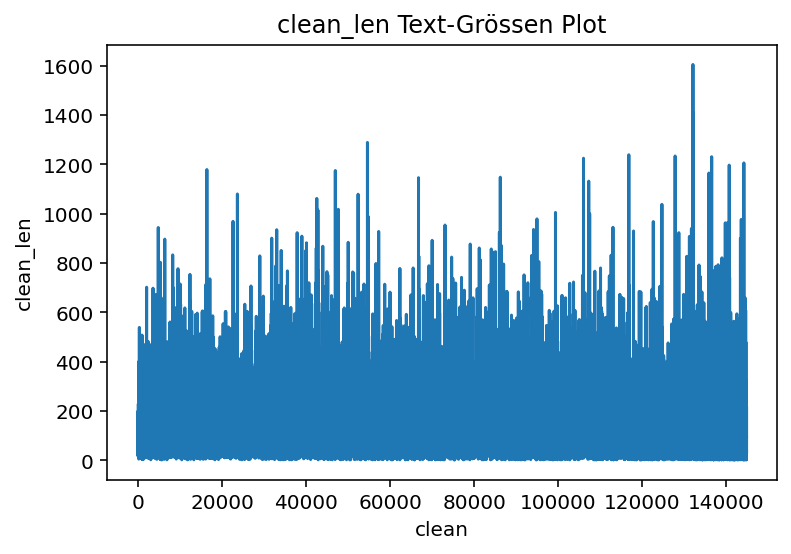

count    144778.000000
mean         80.690637
std          78.647618
min           2.000000
25%          31.000000
50%          56.000000
75%         101.000000
max        1605.000000
dtype: float64


In [25]:
reviewSizes("clean")

## x_TRAIN /  x_TEST sequences

In [26]:
MAX_REV_LENGTH = 80

x_train = create_sequence(df_train) # nimm "clean" erstellt daraus ein pad_sequnces "Seq" und gibt es gleichzeitig zurück
x_test  = create_sequence(df_test)

x_train.shape, x_test.shape

F:\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


((115822, 80), (28956, 80))

In [27]:
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(x_train[0]))

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? it is good to have the toy bar over the pad it keeps my baby busy while business is being taken care off


df_train_downsample = df_train.groupby(["Rate"]).apply(lambda x: x.sample(n=7400, replace=True)).drop(["Rate"], axis=1).reset_index()

In [28]:
print(f"Vocabular Grösse \t{VOCAB_SIZE} \nEmbedding-Dimensionen: \t{EMBEDDING_DIM} \nMaximale Review Länge: \t{MAX_REV_LENGTH} \n ")

Vocabular Grösse 	46632 
Embedding-Dimensionen: 	300 
Maximale Review Länge: 	80 
 


### F1 - Metrikberechner

In [29]:
def F1(y_true, y_pred):

    possible_pos = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_pos = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

    precision = true_pos / (predicted_pos + K.epsilon())
    recall = true_pos / (possible_pos + K.epsilon())
    
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

## RNN: Trainings-Model

In [3]:
from keras.models import Model, Sequential
from keras.layers import Dense, Input, GRU,LSTM, Embedding, Dropout, Activation, CuDNNLSTM, Bidirectional, GlobalAveragePooling1D, SpatialDropout1D, GlobalMaxPooling1D
import tensorflow as tf
from   tensorflow import keras
from keras import optimizers
import tensorflow.keras.layers as layer

from keras.layers.merge import concatenate

def train_model(x_train_data, y_train_data, x_val_data, y_val_data, number_classes, activation_function, 
                 epochs = 20, batch_size = 32, learning_rate = 1e-3, patience=3, rating_weigths = None, extra_drop = False ):

    print(f" Learning-Rate: {learning_rate}\n Epochs: {epochs} \n Activiation-Function: {activation_function} \n")
    print(f" Vocabulary Size: {VOCAB_SIZE}\n Embedding-Dimension: {EMBEDDING_DIM} \n Maximal Reviews length: {MAX_REV_LENGTH} \n ")
    
    inp = Input(shape=(MAX_REV_LENGTH, ), dtype="int32")
    
    x = Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)(inp)
    x = SpatialDropout1D(0.5)(x)
    x = Bidirectional( LSTM(40, return_sequences=True))(x)
    x = Bidirectional( GRU( 40, return_sequences=True))(x)

    if extra_drop:
        x = Dropout(0.3)(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])

    outp = Dense(number_classes, activation=activation_function)(conc)
     
    model = Model(inputs=inp, outputs=outp) 
 
    if number_classes == 1:
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    else:
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy', F1])
  

    model.summary()
    
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience) 
    model.fit(x_train_data, y_train_data,
              callbacks=[callback],
              epochs=epochs,
              batch_size=batch_size,
              validation_data=[x_val_data, y_val_data],
              class_weight = rating_weigths,
              verbose=1)
    
    return model


Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow.python.tools'; 'tensorflow.python' is not a package

# Task1
###### Index : Klasse
* 4 : Rating 5       
* 3 : Rating 4
* 2 : Rating 3
* 1 : Rating 2       
* 0 : Rating 1

#### y_TEST

In [31]:
y_test_task1 = to_categorical( df_test["Task1"], 5, dtype="int8" )

print(x_test.shape, y_test_task1.shape)

(28956, 80) (28956, 5)


### Training mit allen Daten (unbalanced)

1: 9690
2: 7176
3: 10523
4: 20786
5: 67647


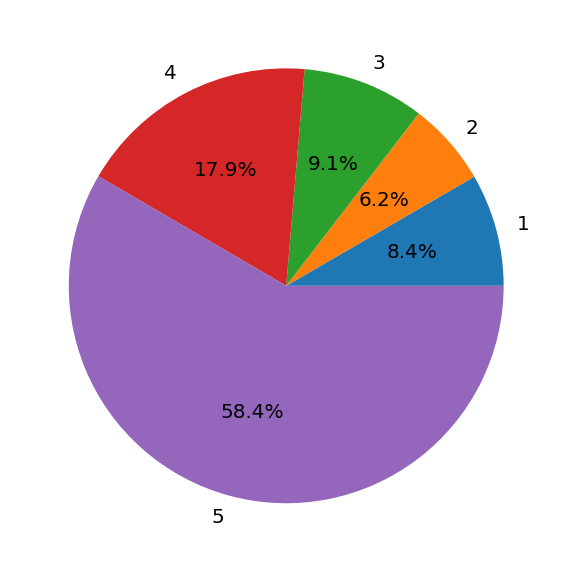

In [32]:
classes_task1 = ["1","2","3","4","5"]
show_rating_values(df_train["Task1"], classes_task1)

#### y_TRAIN

In [33]:
y_train_task1 = to_categorical( df_train["Task1"], 5, dtype="int8")

print(x_train.shape, y_train_task1.shape)
y_train_task1[:10]

(115822, 80) (115822, 5)


array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=int8)

### Train-Model (unbalanced)

In [34]:
model_task1 = train_model(x_train, y_train_task1, 
                          x_test,  y_test_task1, 
                          number_classes = 5, 
                          activation_function = "softmax", 
                          epochs = 20,
                          batch_size = 32, 
                          learning_rate=1e-3,
                          patience = 3)

 Learning-Rate: 0.001
 Epochs: 20 
 Activiation-Function: softmax 

 Vocabulary Size: 46632
 Embedding-Dimension: 300 
 Maximal Reviews length: 80 
 
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 80, 300)      13989600    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 80, 300)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 80

In [35]:
test_predict_task1, evalus_task1, metrics_task1 = y_test_predict(model_task1, x_test, y_test_task1, classes_task1)

28956/28956 [==============================] - 21s 730us/step
[0.710218072867983, 0.7190564870834351, 0.7130404114723206]
28956/28956 [==============================] - 21s 726us/step
              precision    recall  f1-score   support

           1       0.61      0.73      0.66      2409
           2       0.35      0.24      0.28      1748
           3       0.44      0.41      0.42      2601
           4       0.55      0.40      0.46      5315
           5       0.83      0.91      0.87     16883

    accuracy                           0.72     28956
   macro avg       0.56      0.54      0.54     28956
weighted avg       0.70      0.72      0.70     28956



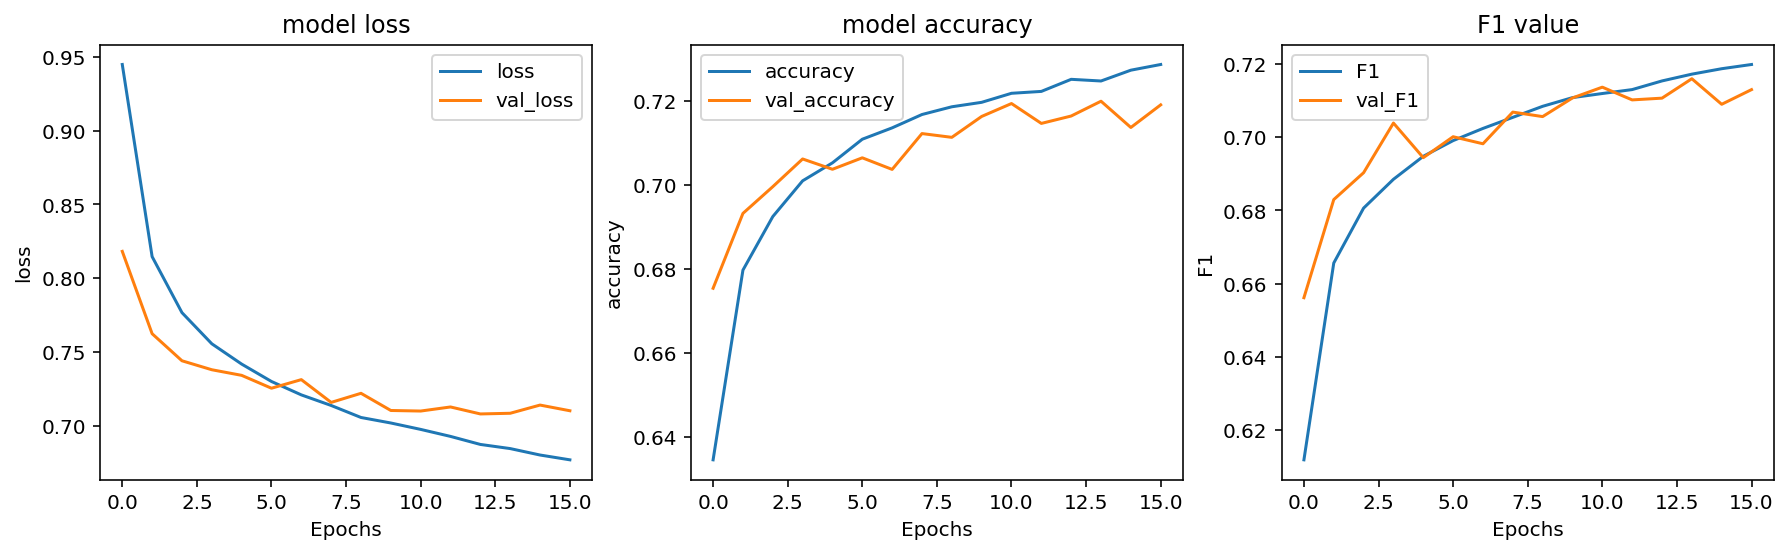

Loss:     0.7102 
Accuracy: 0.7191 
F1:       0.7130 

Confusion matrix
[[ 1762   304   174    36   133]
 [  646   415   444    89   154]
 [  295   325  1073   548   360]
 [   79    85   574  2139  2438]
 [  125    56   192  1078 15432]]


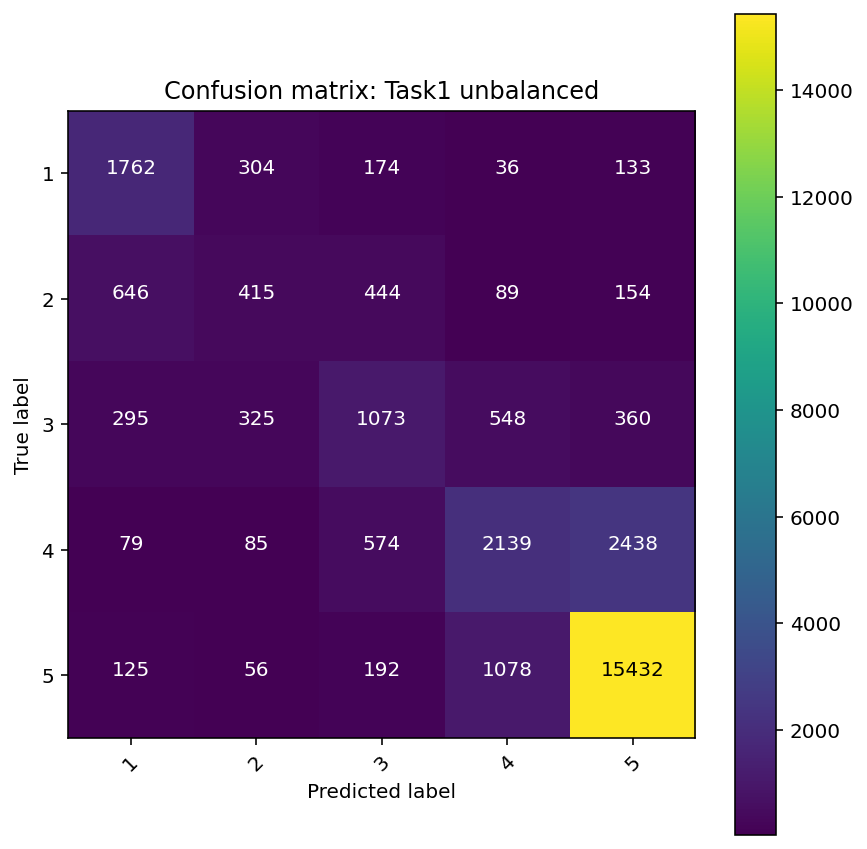

In [36]:
plot_graphs(model_task1)

print_metrics(evalus_task1)

y_pred_class = np.array([np.argmax(x) for x in test_predict_task1])
y_test_class = np.array([np.argmax(x) for x in y_test_task1])

f1_task1_unbalanced = f1_score(y_test_class, y_pred_class, average=None)

cnf_matrix = confusion_matrix(y_test_class, y_pred_class)
plot_confusion_matrix(cnf_matrix, classes=classes_task1, title='Confusion matrix: Task1 unbalanced')

# Task2
###### Index : Klasse
* 2 : Rating 5
* 1 : Rating 4       
* 0 : Rating 3,2,1 (Rest)

#### y_TEST

In [31]:
y_test_task2 = to_categorical( df_test["Task2"], 3, dtype="int8" )

print(x_test.shape, y_test_task2.shape)

y_test_task2[:10]

(28956, 80) (28956, 3)


array([[1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1]], dtype=int8)

### Training mit allen Daten (unbalanced)

Rest: 27389
4: 20786
5: 67647


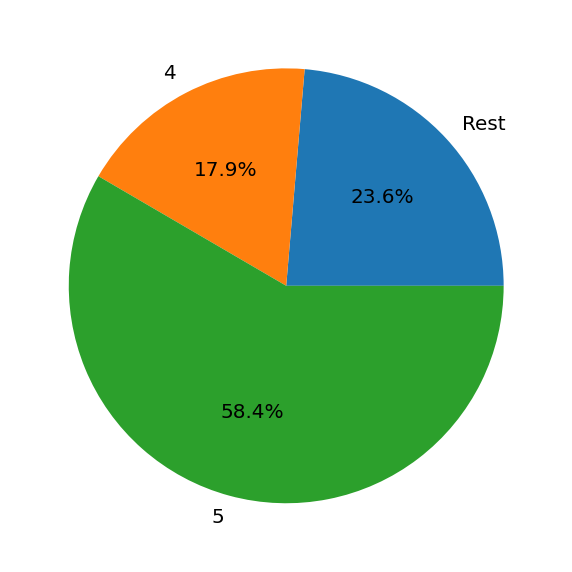

In [32]:
classes_task2 = ["Rest", "4", "5"]
show_rating_values(df_train["Task2"], classes_task2)


#### y_TRAIN

In [33]:
y_train_task2 = to_categorical( df_train["Task2"], 3, dtype="int8" )

print(x_train.shape, y_train_task2.shape)

y_train_task2[:10]

(115822, 80) (115822, 3)


array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=int8)

### Train-Model (unbalanced)

In [34]:
model_task2 = train_model(x_train, y_train_task2, 
                          x_test, y_test_task2, 
                          number_classes = 3, 
                          activation_function = "softmax")

 Learning-Rate: 0.001
 Epochs: 20 
 Activiation-Function: softmax 

 Vocabulary Size: 46632
 Embedding-Dimension: 300 
 Maximal Reviews length: 80 
 
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 80, 300)      13989600    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 80, 300)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 80

KeyboardInterrupt: 

In [ ]:
test_predict_task2, evalus_task2, metrics_task2 = y_test_predict(model_task2, x_test, y_test_task2, classes_task2)

In [ ]:
plot_graphs(model_task2)

print_metrics(evalus_task2)

y_pred_class = np.array([np.argmax(x) for x in test_predict_task2])
y_test_class = np.array([np.argmax(x) for x in y_test_task2])

f1_task2_unbalanced = f1_score(y_test_class, y_pred_class, average=None)


cnf_matrix = confusion_matrix(y_test_class, y_pred_class)
plot_confusion_matrix(cnf_matrix, classes=classes_task2, title='Confusion matrix: Task2 unbalanced')

_________________________________________________________________________________________________________________

# Task3
###### Index : Klasse
* 1 : Rating 1       
* 0 : Rating 2,3,4,5

#### y_TEST

In [36]:
y_test_task3 = to_categorical( df_test["Task3"], 2, dtype="int8" )

print(x_test.shape, y_test_task3.shape)

y_test_task3[:10]

(28956, 80) (28956, 2)


array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0]], dtype=int8)

### Training mit allen Daten (unbalanced)

Rest: 106132
1: 9690


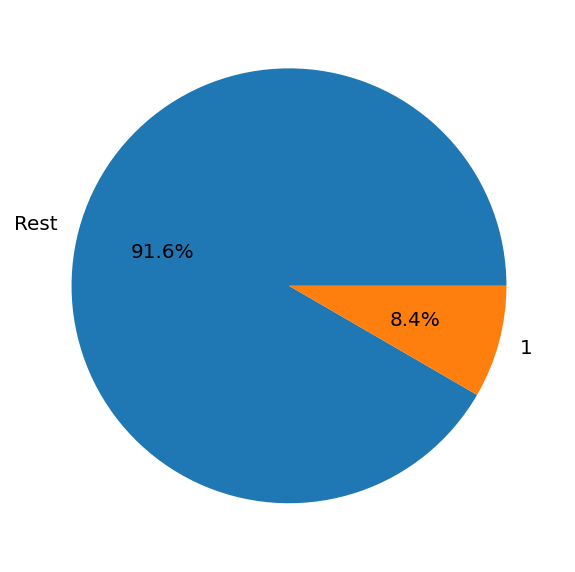

In [37]:
classes_task3 = ["Rest", "1"]
show_rating_values(df_train["Task3"], classes_task3)

#### y_TRAIN

In [38]:
y_train_task3 = to_categorical( df_train["Task3"], 2, dtype="int8" )

print(x_train.shape, y_train_task3.shape)
y_train_task3[:10]

(115822, 80) (115822, 2)


array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int8)

### Train-Model (unbalanced)

In [39]:
model_task3 = train_model(x_train, y_train_task3, 
                          x_test, y_test_task3, 
                          number_classes = 2, 
                          activation_function = "softmax")

 Learning-Rate: 0.001
 Epochs: 20 
 Activiation-Function: softmax 

 Vocabulary Size: 46632
 Embedding-Dimension: 300 
 Maximal Reviews length: 80 
 
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 80)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 80, 300)      13989600    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 80, 300)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 80

KeyboardInterrupt: 

In [ ]:
test_predict_task3, evalus_task3, metrics_task3 = y_test_predict(model_task3, x_test, y_test_task3, classes_task3)

In [ ]:
plot_graphs(model_task3)

print_metrics(evalus_task3)

y_pred_class = np.array([np.argmax(x) for x in test_predict_task3])
y_test_class = np.array([np.argmax(x) for x in y_test_task3])

f1_task3_unbalanced = f1_score(y_test_class, y_pred_class, average=None)


cnf_matrix = confusion_matrix(y_test_class, y_pred_class)
plot_confusion_matrix(cnf_matrix, classes=classes_task3, title='Confusion matrix: Task3 unbalanced')

# Fazit:

In [ ]:
def print_evalus(predicts, string):
    print(f"__________________________________________________ \n{string}")
    for i, val in enumerate(predicts):
        #print(f"Task {i}: ", print_metrics(val))
        print(f"Task {i}: Loss = {val[0]:.3f}, Accuracy = {val[1]:.3f}, F1 = {val[2]:.3f}")
    
all_evals_unbalanced = [evalus_task1, evalus_task2,  evalus_task3]

def print_f1_score(f1_data, string, classes):
    print(f"__________________________________________ \n{string} F1-Scores")
    print("\t\t    F1 ")
    for i, label in enumerate(classes):
        print(f"Class {label}:\t    {f1_data[i]:.4f}")
      
        
print_evalus(all_evals_unbalanced, "Unbalanced Train-Daten")


print_f1_score(f1_task1_unbalanced, "Task1", classes_task1)
print_f1_score(f1_task2_unbalanced, "Task2", classes_task2)
print_f1_score(f1_task3_unbalanced, "Task3", classes_task3)

## Prediction Playground

In [ ]:
def print_predict_rating(task_number, txt):
    txt_seq = tokenizer.texts_to_sequences(txt)
    txt_seq = pad_sequences(
        txt_seq, 
        maxlen=MAX_REV_LENGTH, 
        padding="post",
        truncating="post") 

    if task_number == 1:
        sentiment = model_task1.predict(txt_seq,batch_size=1,verbose = 2)[0]
    elif task_number == 2:
        sentiment = model_task2.predict(txt_seq,batch_size=1,verbose = 2)[0]
    elif task_number == 3:
        sentiment = model_task3.predict(txt_seq,batch_size=1,verbose = 2)[0]
    else:
        print("Keine Gültige Task-Nummer. Wähle 1,2 oder 3")
        
        
    print("Prediction für Text: " + txt)
    print(f"Die Werte  -> {sentiment}")
    print(f"Rating prediction ist: {np.argmax(sentiment) + 1} \n _________________________________")

    
print_predict_rating(1, "Very nice produkt. Can recommend it.")
print_predict_rating(1, "terrible bad crap dont buy terrify")
print_predict_rating(1, "sad")